# Lab6-Assignment: Topic Classification

Use the same training, development, and test partitions of the the 20 newsgroups text dataset as in Lab6.4-Topic-classification-BERT.ipynb

- Fine-tune and examine the performance of another transformer-based pretrained language models, e.g., RoBERTa, XLNet

- Compare the performance of this model to the results achieved in Lab6.4-Topic-classification-BERT.ipynb and to a conventional machine learning approach (e.g., SVM, Naive Bayes) using bag-of-words or other engineered features of your choice.

Describe the differences in performance in terms of Precision, Recall, and F1-score evaluation metrics.

### Install/import libraries
Install the simpletransformers library (restart your runtime after the installation)

In [ ]:
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 113.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 111.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt 
import seaborn as sn 

Import [the 20 newsgroups text dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html).

The dataset contains around 18,000 newsgroups posts on 20 topics.

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# load only a sub-selection of the categories (4 in our case)
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'sci.space'] 

# remove the headers, footers and quotes (to avoid overfitting)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)

### Data exploration

In [ ]:
train = pd.DataFrame({'text': newsgroups_train.data, 'labels': newsgroups_train.target})

In [ ]:
test = pd.DataFrame({'text': newsgroups_test.data, 'labels': newsgroups_test.target})

Use a subset (10%) of the training set as a development set

In [ ]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=0, 
                               stratify=train[['labels']])

### RoBERTa

In [ ]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model 
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase. 
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

model_args.save_best_model=False
model_args.save_eval_checkpoints=False
model_args.save_model_every_epoch=True
model_args.save_optimizer_and_scheduler=False
model_args.save_steps=2000

With this configuration, the training will terminate if the eval_loss on the evaluation data does not improve upon the best eval_loss by at least 0.01 for 2 consecutive evaluations. 

An evaluation will occur once for every 32 training steps.

In [ ]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 64 steps = validating 2 times per epoch

Each epoch will have 64 steps.


Load the pre-trained model: xlm-roberta-base

In [ ]:
model = ClassificationModel('roberta', 'xlm-roberta-base', num_labels=4, args=model_args, use_cuda=True) # CUDA is enabled

You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'cla

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLMRobertaTokenizer'. 
The class this function is called from is 'RobertaTokenizerFast'.


In [ ]:
print(str(model.args).replace(',', '\n')) # model args

ClassificationArgs(adafactor_beta1=None
 adafactor_clip_threshold=1.0
 adafactor_decay_rate=-0.8
 adafactor_eps=(1e-30
 0.001)
 adafactor_relative_step=True
 adafactor_scale_parameter=True
 adafactor_warmup_init=True
 adam_betas=(0.9
 0.999)
 adam_epsilon=1e-08
 best_model_dir='outputs/best_model'
 cache_dir='cache_dir/'
 config={}
 cosine_schedule_num_cycles=0.5
 custom_layer_parameters=[]
 custom_parameter_groups=[]
 dataloader_num_workers=0
 do_lower_case=False
 dynamic_quantize=False
 early_stopping_consider_epochs=False
 early_stopping_delta=0.01
 early_stopping_metric='eval_loss'
 early_stopping_metric_minimize=True
 early_stopping_patience=2
 encoding=None
 eval_batch_size=8
 evaluate_during_training=True
 evaluate_during_training_silent=True
 evaluate_during_training_steps=32
 evaluate_during_training_verbose=False
 evaluate_each_epoch=True
 fp16=True
 gradient_accumulation_steps=1
 learning_rate=4e-06
 local_rank=-1
 logging_steps=50
 loss_type=None
 loss_args={}
 manual_seed=

Fine-tuning the model (takes a while)

In [ ]:
_, history = model.train_model(train, eval_df=dev) 

  0%|          | 0/2025 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

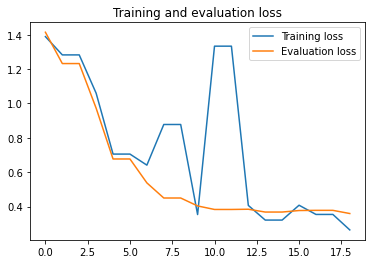

In [ ]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

  0%|          | 0/226 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/29 [00:00<?, ?it/s]

{'mcc': 0.8287070195918593, 'eval_loss': 0.35961795675343483}

Make predictions with the model (predict the labels of the documents in the test set)

In [ ]:
predicted, probabilities = model.predict(test.text.to_list())
test['predicted'] = predicted

  0%|          | 0/1498 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Evaluate the model's performance on the test set

In [ ]:
print(classification_report(test['labels'], test['predicted']))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75       319
           1       0.90      0.87      0.88       389
           2       0.87      0.89      0.88       396
           3       0.84      0.81      0.82       394

    accuracy                           0.84      1498
   macro avg       0.83      0.83      0.83      1498
weighted avg       0.84      0.84      0.84      1498



## SVM Classification of 20 Newsgroups Text Dataset

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [ ]:
vectorizer = CountVectorizer().fit(newsgroups_train.data + newsgroups_test.data)

train = vectorizer.transform(newsgroups_train.data)
test = vectorizer.transform(newsgroups_test.data)

In [ ]:
clf = LinearSVC(C=0.01, max_iter=int(1e5), random_state=228)
clf.fit(train, newsgroups_train.target)
print(classification_report(newsgroups_test.target, clf.predict(test), target_names=newsgroups_test.target_names))

               precision    recall  f1-score   support

  alt.atheism       0.78      0.72      0.75       319
comp.graphics       0.72      0.88      0.79       389
      sci.med       0.86      0.71      0.78       396
    sci.space       0.76      0.78      0.77       394

     accuracy                           0.78      1498
    macro avg       0.78      0.77      0.77      1498
 weighted avg       0.78      0.78      0.78      1498



## Comparing performance of RoBERTa, BERT, and SVM 

**Describe the differences in performance in terms of Precision, Recall, and F1-score evaluation metrics.**

BERT and RoBERTa are very similar models which use transformers and word masking. The difference is that RoBERTa is more robust as it uses dynamic masking (the masked parts change for each epoch) while BERT uses static masking (same part is masked for each epoch). Additionally, RoBERTa is trained on more data points. 

When comparing the overall results, we find them a bit shocking as we believed that RoBERTa would perform better than BERT as it is more robust and trained on more data points, however this was not the case. 

*   When comparing the precision of the two models, we can see that there is only a noticeable difference in terms of label 2 which is “sci.med”. For BERT, the precision for label 2 is 0.92 while for RoBERTa it is 0.86.
*   When comparing recall, RoBERTa has overall a lower recall than BERT. The most noticeable is for label 0 which is “alt.atheism”. For BERT, the recall for label 0 is 0.82 while for RoBERTa it is 0.76.
*   When comparing the F1-score,  RoBERTa has overall a lower F1-score than BERT. There is not one label which is more noticeable. 

We believe the reason for these results could be due to BERT masking the same part of the sentence every time and thus yield more precise results.

Support Vector Machine (SVM) is an established supervised learning technique.Originally it was developed for pattern recognition and regression analysis but it eventually was employed in the several other fields including text classification. 
In this experiment SVM can be taken as a baseline to compare with the more specialised BERT amd RoBERTa models. 

We first transformed the training and test data into document-term matrices and then used them to train the classifier.

As expected, the overall performance is generally lower then BERT and RoBERTa.


*   When comparing precision we can observe generally inferior performances for the SVM with one notable exception. On the 3rd label (sci.med), the SVM achieves the same level of precision that was reached by RoBERTa (0.86) and even surpasses BERT (0.83)
*  When comparing recall, the SVM has generally lower performance the BERT and RoBERTa, only reaching a comparable level for the first two labels
*  The SVM's F1-scores confirm what we can observe in the previous comparison. SVM is scoring lower then both BERT and RoBERTa with no noticeable different on any of the labels.

As expected, without a significant effort in feature engeneering, SVM was outperformed by the pretrained models due to the difficulty of topic classification. Although BERT and RoBERTa scored higher in this particular experiment, SVM may still prove to be a viable option in specific fields. e.g. in the medical field The pretrained models may discard important information given by field-specific language (this can be avoided by manually processing the data)
As noted by Y. Wahba et al.(2022), investing time in carfeully pre-processing and feature engeneering may still yield competitive SVM performances (compared to those of pretrained models). 


